In [77]:
import pandas as pd
import numpy as np
from collections import Counter
from dataclasses import dataclass
from typing import Tuple, List

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_iris

In [2]:
iris = load_iris()
iris_x = iris["data"]
iris_y = iris["target"]

X_train, X_test, Y_train, Y_test = train_test_split(iris_x, iris_y, test_size=0.25, random_state=89)

# Base Model

In [3]:
base_model = RandomForestClassifier()
base_model.fit(X_train, Y_train)

base_model_preds = base_model.predict(X_test)

In [4]:
print(classification_report(Y_test, base_model_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.82      1.00      0.90         9
           2       1.00      0.85      0.92        13

    accuracy                           0.95        38
   macro avg       0.94      0.95      0.94        38
weighted avg       0.96      0.95      0.95        38



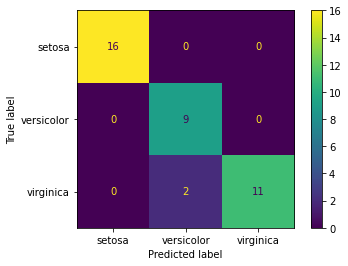

In [5]:
matrix = confusion_matrix(Y_test, base_model_preds)
chart = ConfusionMatrixDisplay(matrix, display_labels=iris.target_names)
chart.plot();

# Implementation Model

In [6]:
@dataclass
class Node:
    """
    Smallest object of a Tree
    """
    feature: np.array = None
    threshold: float = None
    data_left: np.array = None
    data_right: np.array = None
    gain: float = None
    value: float = None

In [58]:
class DecisionTree:
    """
    Build a single decision tree 
    """
    def __init__(self, min_sample_split: int = 2, max_depth: int = 2) -> None:
        self.min_sample_split: int = min_sample_split
        self.max_depth: int = max_depth
        self.root: Node = None
    
    @staticmethod
    def _entropy(vector: np.array) -> float:
        res: float = 0.0
        valid_ints = np.bincount(np.array(vector, dtype=np.int64))
        probabilites = valid_ints / len(vector)
        
        for prob in probabilites:
            if prob > 0:
                res += prob * np.log2(prob)
        
        return -res
    
    def _calculate_gain(self, parent: np.array, left_child: np.array, right_child: np.array) -> float:
        val_left = len(left_child) / len(parent) if len(parent) > 0 else 0
        val_right = len(right_child) / len(parent) if len(parent) > 0 else 0
        
        calc_left = val_left * self._entropy(left_child)
        calc_right = val_right * self._entropy(right_child)
        
        return self._entropy(parent) - (calc_left + calc_right)
        
    def _best_split(self, X: np.array, Y: np.array) -> dict:
        res: dict = {}
        initial_gain = -999
        n_rows, n_cols = X.shape
        
        for idx in range(n_cols):
            X_current = X[:, idx]
            
            for threshold in np.unique(X_current):
                df = np.concatenate((X, Y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[idx] <= threshold])
                df_right = np.array([row for row in df if row[idx] > threshold])
                
                if len(df_left) > 0 and len(df_right) > 0:
                    tgt = df[:, -1]
                    tgt_left = df_left[:, -1]
                    tgt_right = df_right[:, -1]
                    
                    gain = self._calculate_gain(tgt, tgt_left, tgt_right)
                    if gain > initial_gain:
                        initial_gain = gain
                        res = {
                            "feature_idx": idx,
                            "threshold": threshold,
                            "df_left": df_left,
                            "df_right": df_right,
                            "gain": gain
                        }
                        
            
            return res
    
    def _build(self, X: np.array, Y: np.array | List, depth:int = 0) -> Node:
        n_rows, n_cols = X.shape
        
        if n_rows >= self.min_sample_split and depth <= self.max_depth:
            best = self._best_split(X, Y)
            
            if "gain" in best and best["gain"] > 0:
                left_node = self._build(
                    X=best["df_left"][:, :-1],
                    Y=best["df_left"][:, -1],
                    depth= depth + 1
                )
                right_node = self._build(
                    X=best["df_right"][:, :-1],
                    Y=best["df_right"][:, -1],
                    depth= depth + 1
                )
                
                return Node(
                    feature=best["feature_idx"],
                    threshold=best["threshold"],
                    data_left=left_node,
                    data_right=right_node,
                    gain=best["gain"]
                )
        
        return Node(value=Counter(Y).most_common(1)[0][0])
    
    def _predict(self, X: np.array, tree: Node) -> float:
        if tree.value != None:
            return tree.value
        
        feature_val = X[tree.feature]
        if feature_val <= tree.threshold:
            return self._predict(X, tree=tree.data_left)
        else:
            return self._predict(X, tree=tree.data_right)
    
    def train(self, X: np.array, Y: np.array) -> None:
        self.root = self._build(X, Y)
    
    def predict(self, X: np.array) -> np.array:
        return [self._predict(x, self.root) for x in X]

In [61]:
class RandomForest:
    def __init__(self, forest_size:int = 10, min_samples_split:int = 3, max_depth:int = 5) -> None:
        self.forest_size: int = forest_size
        self.min_samples_split: int = min_samples_split
        self.max_depth: int = max_depth
        self.decision_trees: List = []
    
    @staticmethod
    def _sample(X: np.array, Y: np.array) -> Tuple[np.array, np.array]:
        n_rows, n_cols = X.shape
        
        samples = np.random.choice(a=n_rows, size=n_rows, replace=True)
        return X[samples], Y[samples]

    def train(self, X: np.array, Y: np.array) -> None:
        if len(self.decision_trees) > 0:
            self.decision_trees = []
        
        num_tree: int = 0
        while num_tree < self.forest_size:
            mdl = DecisionTree(
                min_sample_split=self.min_samples_split,
                max_depth=self.max_depth
            )

            _X, _Y = self._sample(X, Y)
            mdl.train(_X, _Y)
            self.decision_trees.append(mdl)
            num_tree += 1

    
    def predict(self, X: np.array) -> np.array:
        y: np.array = []
        for tree in self.decision_trees:
            y.append(tree.predict(X))
        
        y = np.swapaxes(a=y, axis1=0, axis2=1)
        
        res: np.array = []
        for preds in y:
            counter = Counter(preds)
            res.append(counter.most_common(1)[0][0])

        return res

In [65]:
mdl = RandomForest(forest_size=100)
mdl.train(X_train, Y_train)

preds = mdl.predict(X_test)

In [66]:
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.50      0.78      0.61         9
           2       0.89      0.62      0.73        13

    accuracy                           0.76        38
   macro avg       0.77      0.76      0.75        38
weighted avg       0.82      0.76      0.77        38



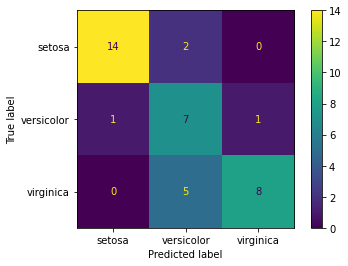

In [68]:
matrix = confusion_matrix(Y_test, preds)
chart = ConfusionMatrixDisplay(matrix, display_labels=iris.target_names)

chart.plot();

# Model with Transposed Features

In [83]:
# Original shape
ft.shape

(112, 4)

In [91]:
ft = pd.DataFrame(X_train)
ft.head()

,0,1,2,3
0,4.6,3.1,1.5,0.2
1,5.6,2.8,4.9,2.0
2,7.9,3.8,6.4,2.0
3,4.8,3.0,1.4,0.3
4,6.3,2.7,4.9,1.8


In [89]:
# Transposed
ft_t = pd.DataFrame(X_train.T)
ft_t.head()

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
0,4.6,5.6,7.9,4.8,6.3,4.9,4.6,6.1,6.7,6.6,...,5.0,5.8,6.3,5.8,5.0,4.6,7.2,6.4,4.8,6.5
1,3.1,2.8,3.8,3.0,2.7,2.4,3.2,2.8,3.1,3.0,...,3.4,2.7,3.4,2.7,3.5,3.6,3.6,2.8,3.1,3.0
2,1.5,4.9,6.4,1.4,4.9,3.3,1.4,4.7,5.6,4.4,...,1.6,3.9,5.6,5.1,1.6,1.0,6.1,5.6,1.6,5.2
3,0.2,2.0,2.0,0.3,1.8,1.0,0.2,1.2,2.4,1.4,...,0.4,1.2,2.4,1.9,0.6,0.2,2.5,2.2,0.2,2.0


In [87]:
ft_t.shape

(4, 112)